# `StableReparam` posteriors

This notebook examines the posteriors over the four latent variables introduced by `StableReparam`, conditioned on a single datum and the `Stable` parameters. Our goal is to assess the accuracy of an `AutoNormal` approximation to this posterior, addressing [Pyro issue #3280](https://github.com/pyro-ppl/pyro/issues/3280).

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.reparam import StableReparam
from pyro.nn.module import PyroModule, PyroParam
from pyro.optim import ClippedAdam
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20231006)
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
stability = 1.9
skew = 0.5
scale = 1.0
loc = 0.0
stable = dist.Stable(stability, skew, scale, loc)

In [3]:
@poutine.reparam(config={"x": StableReparam()})
def model(data: torch.Tensor):
    with pyro.plate("data", len(data)):
        pyro.sample("x", stable, obs=data)

Let's sample some representative points.

In [4]:
data = stable.sample([10001])
data, _ = data.sort()
data.shape

torch.Size([10001])

Text(0.5, 1.0, 'Approximate CDF')

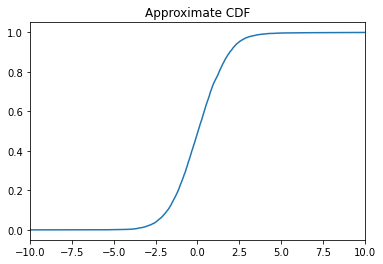

In [5]:
plt.plot(data, torch.linspace(0, 1, len(data)))
plt.xlim(-10, 10)
plt.title("Approximate CDF")

In [6]:
quantiles = torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0])

In [7]:
# draw samples using Pyro's NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=4000, warmup_steps=400)
mcmc.run(quantiles)
samples = mcmc.get_samples()

Warmup:   0%|                                                                                                    | 0/4400 [00:00, ?it/s]

Sample: 100%|████████████████████████████████████████| 4400/4400 [01:23, 52.44it/s, step size=1.96e-01, acc. prob=0.914]                


In [11]:
{k: v.shape for k, v in sorted(samples.items())}

{'x_t_exponential': torch.Size([4000, 5]),
 'x_t_uniform': torch.Size([4000, 5]),
 'x_z_exponential': torch.Size([4000, 5]),
 'x_z_uniform': torch.Size([4000, 5])}

In [12]:
z = torch.stack([v for k, v in sorted(samples.items())], dim=-1)
z.shape

torch.Size([4000, 5, 4])

In [13]:
mcmc.transforms

{'x_z_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_z_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 ),
 'x_t_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_t_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 )}

In [101]:
z_unconstrained = torch.stack(
    [mcmc.transforms[k](v) for k, v in sorted(samples.items())],
    dim=-1
)

In [102]:
def plot_pairs(data_index: int, *z_unconstrained_s) -> None:
    """lots a 4x4 grid of pairwise scatter plots for each of the four dimensions"""
    assert len(z_unconstrained_s) in (1, 2)
    alphas = (1.0, 0.66)
    colors = ("C0", "C1")
    sampless = [z[:, data_index, :].numpy() for z in z_unconstrained_s]
    assert all(s.shape == (len(s), 4) for s in sampless)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i == j:
                for s, alpha, color in zip(sampless, alphas, colors):
                    axs[i, j].hist(s[:, i], bins=50, color=color, alpha=alpha)
            else:
                for s, alpha, color in zip(sampless, alphas, colors):
                    axs[i, j].scatter(s[:, j], s[:, i], s=5, alpha=0.3, lw=0, color=color)
            if i < 3:
                axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    fig.suptitle(f"reparam z | x = {quantiles[data_index]:0.5g}", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)

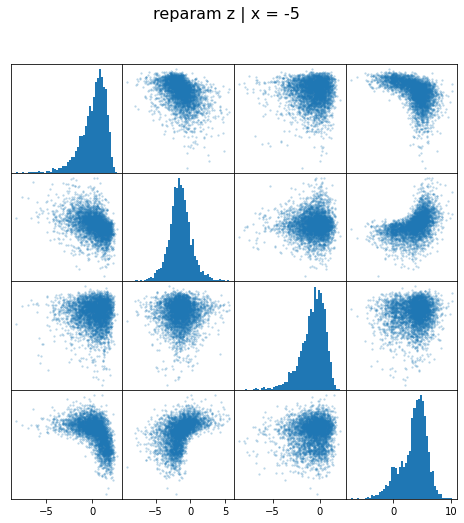

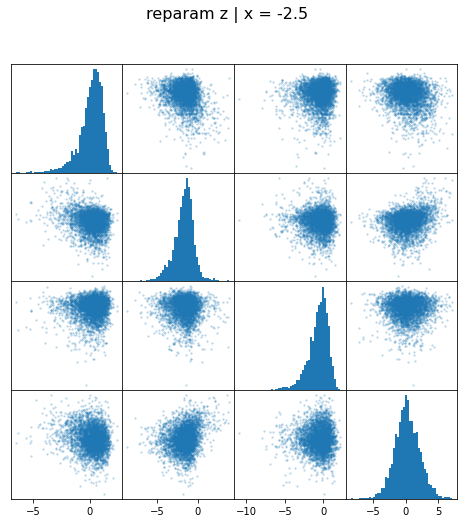

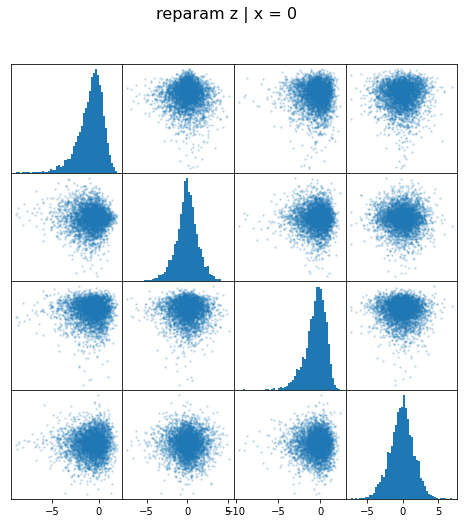

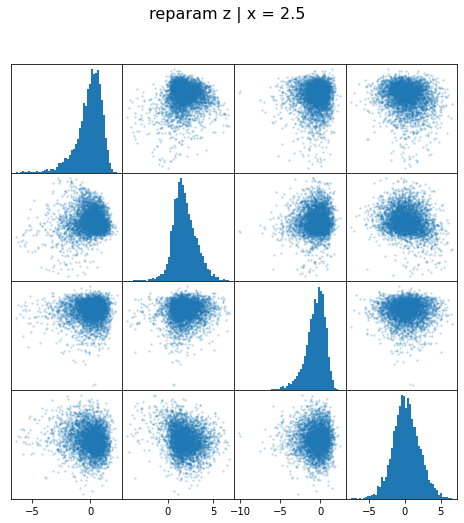

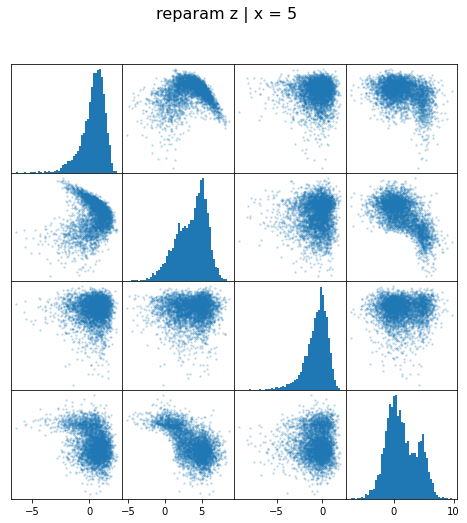

In [103]:
for i in range(len(quantiles)):
    plot_pairs(i, z_unconstrained)

## Fitting an amortized guide

Let's fit an amortized diagonal normal guide, in preparation for more complex guides.

In [168]:
pyro.set_rng_seed(20231007)
data = stable.sample([10000001])[::10]

Let's stratify to put more emphasis on the distribution's tails.

In [169]:
stratified = data.mul(50).round().div(50).unique()
stratified, _ = stratified.sort()
stratified.shape

torch.Size([1793])

In [170]:
for i in range(10):
  stratified = (stratified[1:] + stratified[:-1]) / 2

Text(0.5, 1.0, 'Approximate PDF of stratified samples')

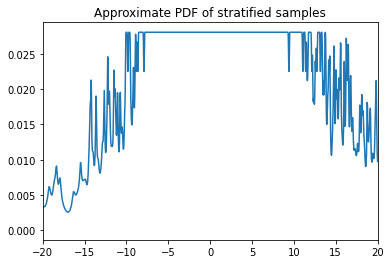

In [174]:
left = stratified[:-1]
right = stratified[1:]
plt.plot((left + right) / 2, 1 / (right - left) / len(stratified))
plt.xlim(-20, 20)
plt.title("Approximate PDF of stratified samples")

In [181]:
class StableGuide(PyroModule):
    """Base class for guides for `StableReparam`."""
    def sample_latents(self, z_unconstrained: torch.Tensor):
        trans_u = dist.transforms.SigmoidTransform()
        trans_e = dist.transforms.SoftplusTransform()
        z_u, z_e, t_u, t_e = z_unconstrained.unbind(-1)
        z_u_ = trans_u(z_u)
        z_e_ = trans_e(z_e)
        t_u_ = trans_u(t_u)
        t_e_ = trans_e(t_e)
        pyro.sample("x_z_uniform", dist.Delta(z_u_, log_density=trans_u.inv.log_abs_det_jacobian(z_u_, z_u)))
        pyro.sample("x_z_exponential", dist.Delta(z_e_, log_density=trans_e.inv.log_abs_det_jacobian(z_e_, z_e)))
        pyro.sample("x_t_uniform", dist.Delta(t_u_, log_density=trans_u.inv.log_abs_det_jacobian(t_u_, t_u)))
        pyro.sample("x_t_exponential", dist.Delta(t_e_, log_density=trans_e.inv.log_abs_det_jacobian(t_e_, t_e)))

class AmortizedNormalGuide(StableGuide):
    def __init__(self, data: torch.Tensor):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.Tanh(),
            torch.nn.Linear(8, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 2 * 4),
        )

        # Initialize to zero mean, small variance.
        with torch.no_grad():
            mean = self.net(data[..., None]).mean(dim=0)
            self.net[-1].bias.data -= mean
            self.net[-1].bias.data[4:] -= 4

    def forward(self, data: torch.Tensor):
        loc, scale = self.net(data[..., None]).chunk(2, dim=-1)
        scale = torch.nn.functional.softplus(scale)
        with pyro.plate("data", len(data)):
            z_unconstrained = pyro.sample(
                "z_unconstrained",
                dist.Normal(loc, scale).to_event(1),
                infer={"is_auxiliary": True},
            )
            self.sample_latents(z_unconstrained)
        return z_unconstrained
        

step:    0 loss: 176.72
step:  200 loss: 48.674
step:  400 loss: 37.789
step:  600 loss: 36.924
step:  800 loss: 37.017
step: 1000 loss: 37.016
step: 1200 loss: 36.814
step: 1400 loss: 36.884
step: 1600 loss: 36.86
step: 1800 loss: 36.874
step: 2000 loss: 36.822
step: 2200 loss: 36.772
step: 2400 loss: 36.795
step: 2600 loss: 36.82
step: 2800 loss: 36.796
step: 3000 loss: 36.77
step: 3200 loss: 36.769
step: 3400 loss: 36.769
step: 3600 loss: 36.764
step: 3800 loss: 36.769
step: 4000 loss: 36.764
step: 4200 loss: 36.76
step: 4400 loss: 36.743
step: 4600 loss: 36.76
step: 4800 loss: 36.768
step: 5000 loss: 36.756


(36.70479838242043, 176.72156493648515)

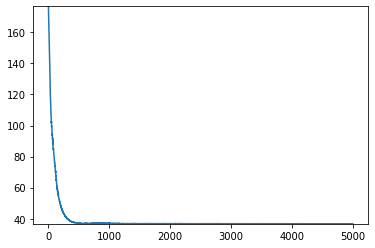

In [182]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 5001
guide = AmortizedNormalGuide(data)
elbo = Trace_ELBO()
optim = ClippedAdam({"lr": 0.01, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    loss = svi.step(stratified) / len(stratified)
    losses.append(loss)
    if step % 200 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

plt.plot(losses)
plt.ylim(min(losses), losses[0])

In [183]:
with torch.no_grad(), pyro.plate("samples", 4000, dim=-2):
    z_unconstrained_svi = guide(quantiles)
z_unconstrained_svi.shape

torch.Size([4000, 5, 4])

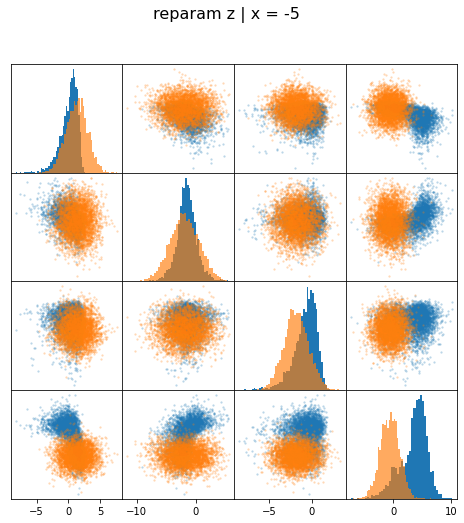

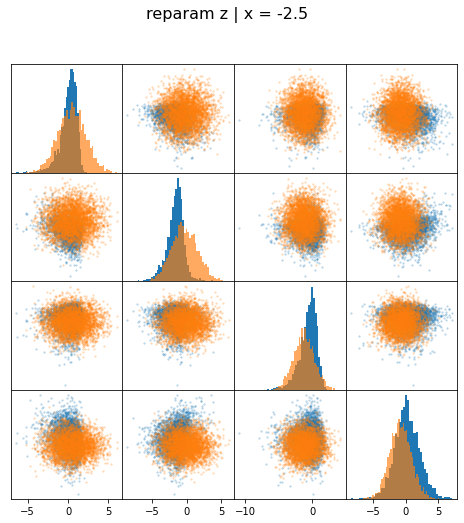

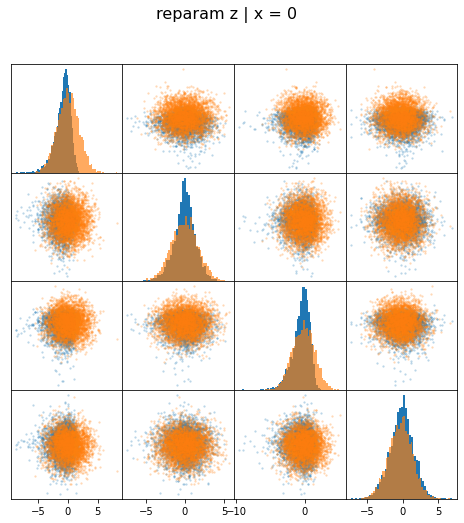

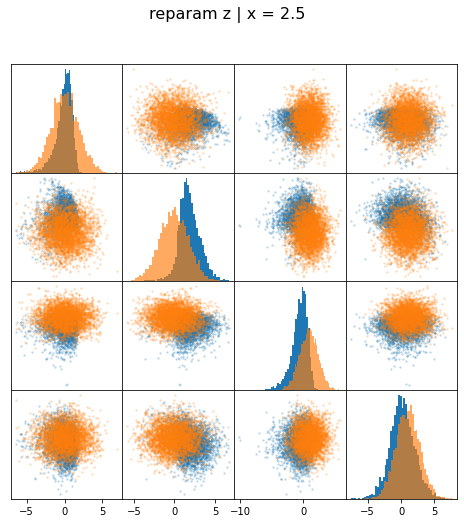

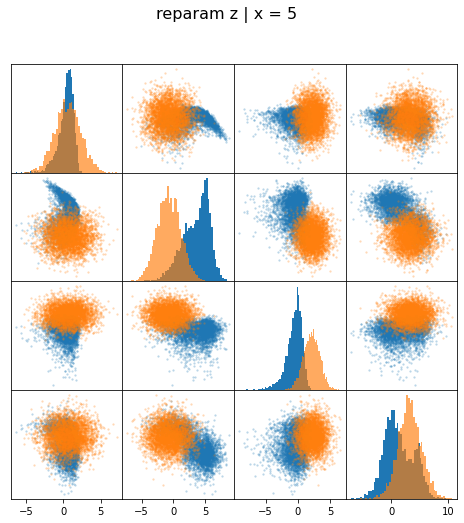

In [184]:
for i in range(len(quantiles)):
    plot_pairs(i, z_unconstrained, z_unconstrained_svi)

Why are predicted locations so bad for tail values of x?

## Fitting a conditional normalizing flow

Let's fit a conditional normalizing flow that depends only on the data point. In a real application we'd want to additionally depend on the local parameters of the stable distribution (stability, skew, scale, and loc).

In [185]:
from pyro.distributions.transforms.planar import ConditionedPlanar

class FlowGuide(StableGuide):
    def __init__(self, data: torch.Tensor, num_flows = 8):
        super().__init__()
        self.num_flows = num_flows
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.Tanh(),
            torch.nn.Linear(8, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 2 * 4 + num_flows * 3 * 4),
        )

        # Initialize to zero mean, small variance.
        with torch.no_grad():
            mean = self.net(data[..., None])[..., :8].mean(dim=0)
            self.net[-1].bias.data[:8] -= mean
            self.net[-1].bias.data[4:8] -= 4

    def forward(self, data: torch.Tensor):
        with pyro.plate_stack("data", data.shape):
            params = self.net(data[..., None])
            loc = params[..., :4]
            scale = params[..., 4:8]
            scale = torch.nn.functional.softplus(scale)
            base_dist = dist.Normal(loc, scale).to_event(1)
            trans_params = params[..., 8:].reshape(params.shape[:-1] + (self.num_flows, 3, 4))
            transforms = [
                ConditionedPlanar(p.unbind(-2)) for p in trans_params.unbind(-3)
            ]
            z_dist = dist.TransformedDistribution(base_dist, transforms)
            z_unconstrained = pyro.sample(
                "z", z_dist, infer={"is_auxiliary": True},
            )
            self.sample_latents(z_unconstrained)
        return z_unconstrained

/Users/fritzo/github/pyro-ppl/pyro/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'data_0'}
  warnings.warn(


step:    0 loss: 180.68
step:  200 loss: 39.086
step:  400 loss: 38.933
step:  600 loss: 37.708
step:  800 loss: 37.597
step: 1000 loss: 38.252
step: 1200 loss: 37.311
step: 1400 loss: 37.348
step: 1600 loss: 36.792
step: 1800 loss: 37.767
step: 2000 loss: 36.584
step: 2200 loss: 38.382
step: 2400 loss: 36.692
step: 2600 loss: 36.907
step: 2800 loss: 36.642
step: 3000 loss: 36.618
step: 3200 loss: 36.63
step: 3400 loss: 36.714
step: 3600 loss: 36.379
step: 3800 loss: 36.404
step: 4000 loss: 36.369
step: 4200 loss: 36.667
step: 4400 loss: 36.441
step: 4600 loss: 36.29
step: 4800 loss: 36.265
step: 5000 loss: 36.216


(36.112053366644, 180.68196936087008)

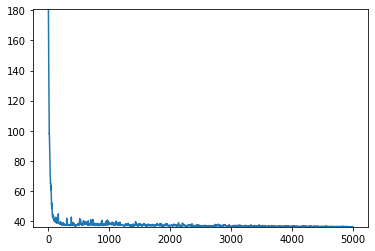

In [186]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 5001
guide = FlowGuide(data)
elbo = Trace_ELBO()
optim = ClippedAdam({"clip_norm": 100, "lr": 0.01, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    loss = svi.step(stratified) / len(stratified)
    losses.append(loss)
    if step % 200 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

plt.plot(losses)
plt.ylim(min(losses), losses[0])

In [187]:
num_samples = 4000
with torch.no_grad():
  z_unconstrained_svi = guide(torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0]).expand(num_samples, -1))
z_unconstrained_svi.shape

torch.Size([4000, 5, 4])

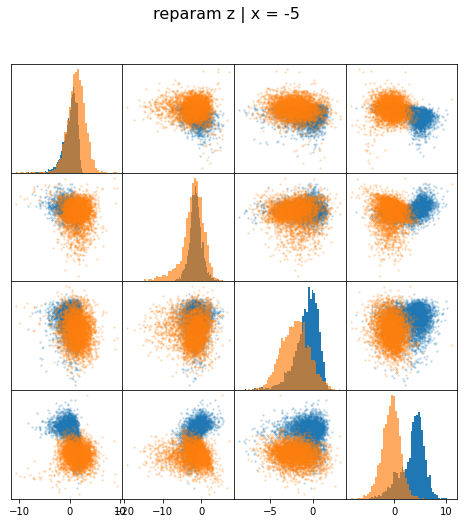

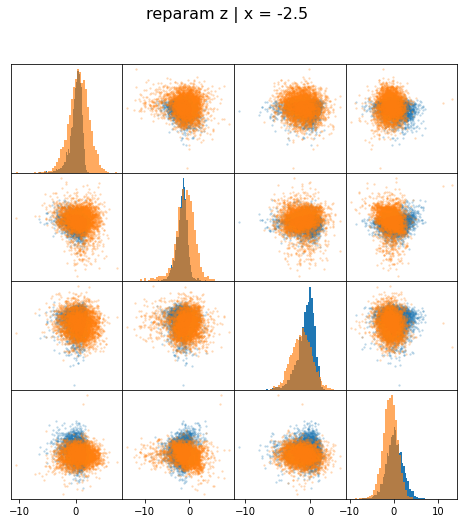

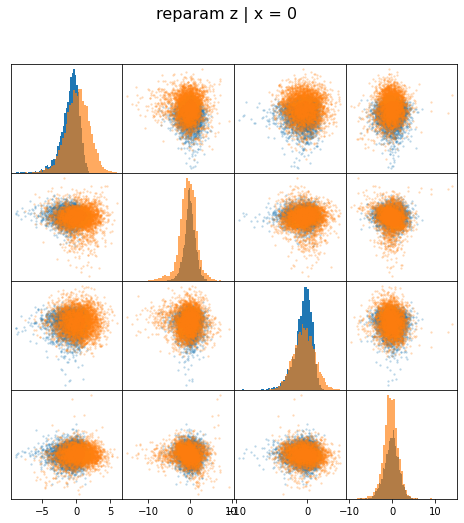

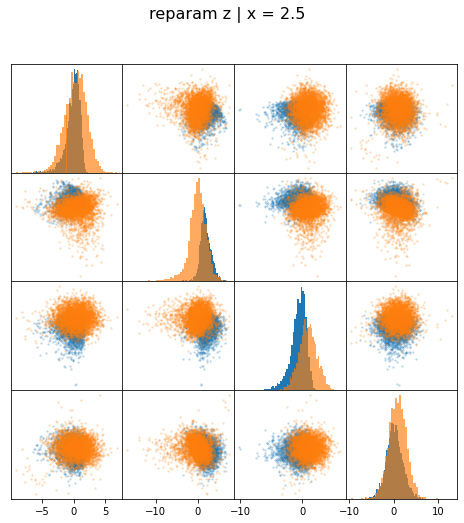

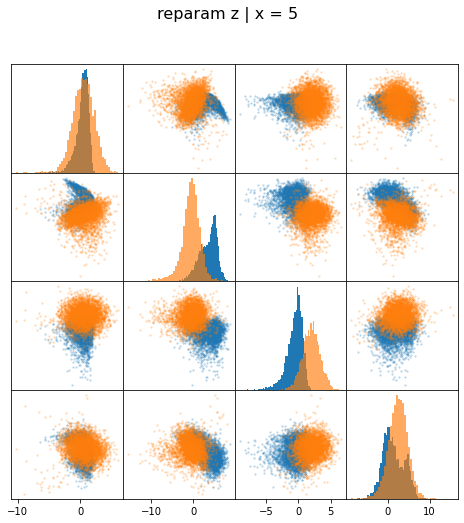

In [188]:
for i in range(len(quantiles)):
  plot_pairs(i, z_unconstrained, z_unconstrained_svi)

Why are the fits so good at x=0 but so bad for x far from zero?